# Υπολογισμός διαγραμμάτων Μ-θ σύμφωνα με τον ΚΑΝ.ΕΠΕ.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol

## Δεδομένα παραδείγματος

Δίνεται η διατομή του σχήματος που βρίσκεται στους ακραίους στύλους του ισογείου του φορέα των σημειώσεων.

![Imgur](https://i.imgur.com/TyiAeHe.png)


### Διαστάσεις της διατομής

$b=0.25m$

$h=0.65m$

### Υλικά

$f_c= 16MPa = 16000kPa$

$E_c=25.3GPa=25300000kPa$

$f_y= 500MPa = 500000kPa$

$E_s= 200GPa = 200000000kPa$

$f_{yw}= 500MPa=500000kPa$

### Οπλισμός

$c_{nom}=30mm = 0.03m$

$\emptyset_{L}=18mm = 0.018m$

$A_s = 12.72cm^2$ για 5∅18

$\emptyset_{L}^{'}=18mm = 0.018m$

$A_s = 7.63cm^2$ για 3∅18

$\emptyset_{Lv}=0mm = 0m$ Δεν υπάρχει ενδιάμεσος οπλισμός στη δοκό

$A_{sv} = 0cm^2$ 

$\emptyset_{d}=0mm = 0m$ Δεν υπάρχει δισδιαγώνιος οπλισμός στη δοκό

$A_{sd} = 0cm^2$ 

$\emptyset_{w}=8mm = 0.008m$

$A_{sw} = 1.01cm^2$ για 2τμητους ∅8

$s=150mm=0.15m$ Η απόσταση μεταξύ των συνδετήρων

### Διαστάσεις του δομικού στοιχείου

$L_s = 2.525m$ το μήκος διάτμησης




## Δεδομένα χρήστη

Στο επόμενο κελί βάζετε τα δεδομένα σας. Προσοχή στις μονάδες

In [2]:
# Διαστάσεις της διατομής
b = 0.45 # το πλάτος της θλιβόμενης ζώνης[m] 
h = 0.45 # το ύψος της διατομής[m]


# Υλικά
fc = 16000.0      # η θλιπτική αντοχή του σκυροδέματος[kPa] 
Ec = 25300000.0   # το μέτρο ελαστικότητας του σκυροδέματος [kPa] 
fy = 500000.0     # το όριο διαρροής του χάλυβα [kPa] 
Es = 200000000.0  # το μέτρο ελαστικότητας του χάλυβα [kPa] 
fyw = 500000.0    # το όριο διαρροής του χάλυβα των συνδετήρων [kPa]



# Οπλισμός
## Επικάλυψη
cnom = 0.03       # [m] 
## Διαμήκης 
### Εφελκυόμενος
nL = 3            # Ο αριθτμός των εφελκυόμενων ράβδων
ΦL = 0.018        # Η διάμετρος των εφελκυόμενων ράβδων [m] 
### Θλιβόμενος
nL2 = 3           # Ο αριθτμός των θλιβόμενων ράβδων
ΦL2 = 0.018       # Η διάμετρος των θλιβόμενων ράβδων [m] 
### Ενδιάμεσος
nLv = 2           # Ο αριθτμός των ενδιάμεσων ράβδων
ΦLv = 0.018       # Η διάμετρος των ενδιάμεσων ράβδων [m] 
## Δισδιαγώνιος 
nd = 0            # Ο αριθτμός των δισδιαγώνιων ράβδων
Φd = 0.           # Η διάμετρος των δισδιαγώνιων ράβδων [m] 
## Εγκάρσιος
nw = 3            # Ο αριθμός των "τμήσεων" των συνδετήρων (πχ. 2 για 2τμητους)
Φw = 0.008        # Η διάμετρος των συνδετήρων [m] 
s = 0.12          # Η απόσταση μεταξύ των συνδετήρων [m] 
# Asw=1.01cm2Asw=1.01cm2 για 2τμητους ∅8

# Αξονικό φορτίο
N = 270.14            # Αξονικό φορτίο για το συνδυασμό G+0.3Q [kN]

# Μήκος διάτμησης
Ls = 1.7        # [m]

# Αποστάσεις bi περίσφιξης [m]
# Υπολογίζονται με το χέρι (όχι αυτόματα)
bi = np.array([0.191, 0.191, 0.191, 0.191, 0.191, 0.191, 0.191, 0.191]) 

## Συναρτήσεις για τη δεδομένα της διατομής και τα ποσοστά οπλισμού

Δεν απαιτείται να τις τροποποιήσετε

In [3]:
# Υπολογισμός As για n ράβδους διαμέτρου Φ. Δουλεύει και με numpy arrays
def As_for_n_Φ(n, Φ):
    if isinstance(n, np.ndarray):
        return sum(n * Φ**2 * np.pi/4)
    else:
        return (n * Φ**2 * np.pi/4)

# Υπολογισμός d1
def d1calc(c, dL, dw):
    return c + dw + 0.5 * dL

# Ποσοστό οπλισμού
def ρcalc(A, b, d):
    return A / (b * d)

# Μηχανικό ποσοστό οπλισμού
def ωcalc(A: float, b: float, d: float, fy: float, fc: float):
    return A / (b * d) * (fy / fc)

# Ποσοστό εγκάρσιου οπλισμού ΚΑΝ.ΕΠΕ.
def ρscalc(A, b, s):
    return A / (b * s)

# Ποσοστό εγκάρσιου οπλισμού EC2
def ρwcalc(A, b, s, α):
    return A / (b * s * np.sin(α))

## Συναρτήσεις για τον υπολογισμό της καμπυλότητας και της ροπής διαρροής

In [4]:
def ξycalc(α, A, B):
    return (α**2 * A**2 + 2 * α * B)**0.5 - α*A 
    
def Mycalc(b, d, φy, Ec, ξy, δ2, ρ1, ρ2, ρv, Es):
    return b * d**3 * φy * (0.5 * Ec * ξy**2 * (0.5*(1 + δ2) -ξy/3) + ((1 - ξy) * ρ1 + (ξy - δ2) * ρ2 + ρv * (1 - δ2)/6)*(1-δ2)*Es/2)

# (0.5*Ec*ξy**2)*(0.5*(1+δtonos)-ξy/3)+((1-ξy)*ρ1+(ξy-δtonos)* ρ2+ρv*(1-δtonos)/6)*(1-δtonos)*Es/2)  
    
def ABξφ_steel(ρ, ρ2, ρv, N, b, d, δ2, fy, α, Es):
    A = ρ + ρ2 + ρv + N / (b * d * fy)
    B = ρ + ρ2 * δ2 + 0.5 * ρv * (1 + δ2) + N / (b * d * fy)
    ξy = ξycalc(α, A, B)
    φy = fy / (Es * (1 - ξy) * d)
    return A, B, ξy, φy

def ABξφ_conc(ρ, ρ2, ρv, N, b, d, δ2, α, Ec, fc):
    A = ρ + ρ2 + ρv - N / (1.8 * α * b * d * fc)
    B = ρ + ρ2 * δ2 + 0.5 * ρv * (1+δ2)
    ξy = ξycalc(α, A, B)
    φy = 1.8 * fc / (Ec * ξy * d)
    return A, B, ξy, φy

## Συναρτήσεις για τον υπολογισμό της στροφής διαρροής 

In [5]:
def VRc(ρtot, d, fc, N, Ac):
    # Ο ΚΑΝ.ΕΠΕ. μάλλον έχει λάθος σχέση. Πολύ μεγάλα νούμερα και μάλλον τάσεις. Πολλαπλασιασμό με b*d ίσως
    # fc [MPa]
    # N [kN] θετικ΄η η θλ΄ίψη
    # διαστάσεις σε [m]
    v1 = max(180. * (100. * ρtot)**(1./3.),
             35. * (1. + (0.2/d)**0.5)**0.5 * fc**(1./6.)
            )
    
    return (v1 * (1 + (0.2/d)**0.5) * fc**(1/3) + 0.15 * N / Ac)*Ac
    
def VRdcEC2(CRdc, Asl, fck, σcp, bw, d):
    ρl = min(Asl / (bw * d), 0.02)
    k = min(1 + (200.0 / d)**0.5, 2.0)
    vmin = 0.035 * k**1.5 * fck**0.5
    k1 = 0.15

    VRdc1 = (CRdc * k * ((100 * ρl * fck)**(1/3)) + k1 * σcp) * bw * d
    VRdc2 = (vmin + k1 * σcp) * bw * d

    _VRdc = max(VRdc1, VRdc2)   
    return ρl, k, vmin, k1, VRdc1, VRdc2, _VRdc

def θycalc(φy, Ls, av, z, h, db, fy, fc):
    # (fy και fc σε MPa)
    fy /= 1000
    fc /= 1000
    return φy * (Ls + av*z) / 3 + 0.0014 * (1 + 1.5 * h/Ls) + φy*db*fy / (8 * fc**0.5)



## Συναρτήσεις για τον υπολογισμό της στροφής αστοχίας


In [6]:
def θumcalc(ν, ωtot, ω2, αs, α, ρs, ρd, fc, fyw):
    part1 = (fc * max(0.01, ω2) / max(0.01, (ωtot-ω2)))**0.225
    part2 = αs**0.35
    part3 = 25.0**(α * ρs * fyw / fc)
    part4 = 1.25**(100 * ρd)
    return 0.016 * 0.3**ν * part1 * part2 * part3 * part4


def αcalc(sh, bc, hc, Σbi2):
    return (1-sh/(2*bc))*(1-sh/(2*hc))*(1-Σbi2/(6*bc*hc))

## Διατμητική αντοχή

In [7]:
# Τέμνουσα που παραλαμβάνουν οι συνδετήρες
def Vwcalc(ρw, bw, z, fyw):
    return ρw * bw * z * fyw

# Τέμνουσα αντοχής
def VRcalc(h, x, Ls , N, Ac, fc, μθpl, ρtot, αs, Vw):
    # Η σχέση θέλει MN και m. Αποτέλεσμα σε MN
    # Θετική η θλίψη, 0 ο εφελκυσμός
    if N < 0: N = 0
    part1 = ((h-x)/(2*Ls)) * min(N, 0.55 * Ac * fc)
    part2 = 1.0 - 0.05 * min(5, μθpl)
    part3 = 0.16 * max(0.5, 100 * ρtot)*(1 - 0.16 * min(5, αs)) * fc**0.5 * Ac + Vw
    return part1 + part2 * part3

# Αποτελέσματα

In [8]:
αs = Ls / h
print(f'Λόγος διάτμησης: αs = {αs:.2f}')

Λόγος διάτμησης: αs = 3.78


## Εμβαδά οπλισμού

In [9]:
As = As_for_n_Φ(nL, ΦL)
print(f'Εμβαδό του εφελκυόμενου οπλισμού: As = {As:.6f}m2 = {10000*As:.2f}cm2')

As2 = As_for_n_Φ(nL2, ΦL2)
print(f'Εμβαδό του θλιβόμενου οπλισμού: As2 = {As2:.6f}m2 = {10000*As2:.2f}cm2')

Asv = As_for_n_Φ(nLv, ΦLv)
print(f'Εμβαδό του ενδιάμεσου οπλισμού: Asv = {Asv:.6f}m2 = {10000*Asv:.2f}cm2')

Asd = As_for_n_Φ(nd, Φd)
print(f'Εμβαδό του δισδιαγώνιου οπλισμού: Asd = {Asd:.6f}m2 = {10000*Asd:.2f}cm2')

Asw = As_for_n_Φ(nw, Φw)
print(f'Εμβαδό του εγκάρσιου οπλισμού: Asw = {Asw:.6f}m2 = {10000*Asw:.2f}cm2')

Astot = As + As2 + Asv
print(f'Συνολικό εμβαδό του διαμήκους οπλισμού: Astot = {Astot:.6f}m2 = {10000*Astot:.2f}cm2')

Εμβαδό του εφελκυόμενου οπλισμού: As = 0.000763m2 = 7.63cm2
Εμβαδό του θλιβόμενου οπλισμού: As2 = 0.000763m2 = 7.63cm2
Εμβαδό του ενδιάμεσου οπλισμού: Asv = 0.000509m2 = 5.09cm2
Εμβαδό του δισδιαγώνιου οπλισμού: Asd = 0.000000m2 = 0.00cm2
Εμβαδό του εγκάρσιου οπλισμού: Asw = 0.000151m2 = 1.51cm2
Συνολικό εμβαδό του διαμήκους οπλισμού: Astot = 0.002036m2 = 20.36cm2


## Γεωμετρικά στοιχεία οπλισμού

In [10]:
d1 = d1calc(cnom, ΦL, Φw)
print(f'Συνολική επικάλυψη εφελκυόμενου: d1={d1:.3f}m')

d2 = d1calc(cnom, ΦL2, Φw)
print(f'Συνολική επικάλυψη θλιβόμενου: d`=d2={d2:.3f}m')

d = h - d1
print(f'Στατικό ύψος: d={d:.3f}m')

δ2 = d2/d
print(f'Λόγος δ`={δ2:.3f}')

sh = s  #- Φw
print(f'Απόσταση των συνδετήρων: sh={sh:.3f}m')
print('Παρατήρηση: Σε παλιότερες εκδόσεις του ΚΑΝ.ΕΠΕ. ως sh ορίζονταν η καθαρή απόσταση s-Φw')
print('')
z = d - d2
print(f'Ο μοχλοβραχίονας εσωτερικών δυνάμεων: z={z:.3f}m')

Συνολική επικάλυψη εφελκυόμενου: d1=0.047m
Συνολική επικάλυψη θλιβόμενου: d`=d2=0.047m
Στατικό ύψος: d=0.403m
Λόγος δ`=0.117
Απόσταση των συνδετήρων: sh=0.120m
Παρατήρηση: Σε παλιότερες εκδόσεις του ΚΑΝ.ΕΠΕ. ως sh ορίζονταν η καθαρή απόσταση s-Φw

Ο μοχλοβραχίονας εσωτερικών δυνάμεων: z=0.356m


## Ποσοστά οπλισμού

In [11]:
ρ = ρcalc(As, b, d)
ω = ωcalc(As, b, d, fy, fc)
print(f'Ποσοστό του εφελκυόμενου οπλισμού: ρ = {ρ:.5f} = {1000*ρ:.2f}‰')
print(f'Μηχανικό ποσοστό του εφελκυόμενου οπλισμού: ω = {ω:.3f}')
print()

ρ2 = ρcalc(As2, b, d)
ω2 = ωcalc(As2, b, d, fy, fc)
print(f'Ποσοστό του θλιβόμενου οπλισμού: ρ` = ρ2 = {ρ2:.5f} = {1000*ρ2:.2f}‰')
print(f'Μηχανικό ποσοστό του θλιβόμενου οπλισμού: ω` = ω2 = {ω2:.3f}')
print()

ρv = ρcalc(Asv, b, d)
ωv = ωcalc(Asv, b, d, fy, fc)
print(f'Ποσοστό του ενδιάμεσου οπλισμού: ρv = {ρv:.5f} = {1000*ρv:.2f}‰')
print(f'Μηχανικό ποσοστό του ενδιάμεσου οπλισμού: ωv = {ωv:.3f}')
print()

ρtot = ρ + ρ2 + ρv
ωtot = ω + ω2 + ωv
print(f'Συνολικό ποσοστό του διαμήκους οπλισμού: ρtot = {ρtot:.5f} = {1000*ρtot:.2f}‰')
print(f'Συνολικό μηχανικό ποσοστό του διαμήκους οπλισμού: ωtot = {ωtot:.3f}')
print()

ρd = ρcalc(Asd, b, d)
ωd = ωcalc(Asd, b, d, fy, fc)
print(f'Ποσοστό του δισδιαγώνιου οπλισμού: ρd = {ρd:.5f} = {1000*ρd:.2f}‰')
print(f'Μηχανικό ποσοστό του δισδιαγώνιου οπλισμού: ωd = {ωd:.3f}')
print()

ρs = ρscalc(Asw, b, sh)
print(f'Ποσοστό του εγκάρσιου οπλισμού (σχέση ΚΑΝ.ΕΠΕ.): ρs = {ρs:.5f} = {1000*ρs:.2f}‰')

ρw = ρwcalc(Asw, b, s, np.pi/2)
print(f'Ποσοστό του εγκάρσιου οπλισμού (σχέση EC2): ρw = {ρw:.5f} = {1000*ρw:.2f}‰')

Ποσοστό του εφελκυόμενου οπλισμού: ρ = 0.00421 = 4.21‰
Μηχανικό ποσοστό του εφελκυόμενου οπλισμού: ω = 0.132

Ποσοστό του θλιβόμενου οπλισμού: ρ` = ρ2 = 0.00421 = 4.21‰
Μηχανικό ποσοστό του θλιβόμενου οπλισμού: ω` = ω2 = 0.132

Ποσοστό του ενδιάμεσου οπλισμού: ρv = 0.00281 = 2.81‰
Μηχανικό ποσοστό του ενδιάμεσου οπλισμού: ωv = 0.088

Συνολικό ποσοστό του διαμήκους οπλισμού: ρtot = 0.01123 = 11.23‰
Συνολικό μηχανικό ποσοστό του διαμήκους οπλισμού: ωtot = 0.351

Ποσοστό του δισδιαγώνιου οπλισμού: ρd = 0.00000 = 0.00‰
Μηχανικό ποσοστό του δισδιαγώνιου οπλισμού: ωd = 0.000

Ποσοστό του εγκάρσιου οπλισμού (σχέση ΚΑΝ.ΕΠΕ.): ρs = 0.00279 = 2.79‰
Ποσοστό του εγκάρσιου οπλισμού (σχέση EC2): ρw = 0.00279 = 2.79‰


## Υπολογισμός της καμπυλότητας και της ροπής διαρροής

In [12]:
α = Es/Ec
print(f'α = {α:.3f}')

α = 7.905


### Διαρροή λόγω χάλυβα

In [13]:
A_steel, B_steel, ξy_steel, φy_steel = ABξφ_steel(ρ, ρ2, ρv, N, b, d, δ2, fy, α, Es)
print(f'A = {A_steel:.5f}')
print(f'B = {B_steel:.5f}')
print(f'ξy = {ξy_steel:.3f}')
print(f'φy = {φy_steel:.5f}m-1')

A = 0.01420
B = 0.00925
ξy = 0.286
φy = 0.00869m-1


### Διαρροή λόγω μη-γραμμικότητας των παραμορφώσεων του θλιβόµενου σκυροδέματος

In [14]:
A_conc, B_conc, ξy_conc, φy_conc = ABξφ_conc(ρ, ρ2, ρv, N, b, d, δ2, α, Ec, fc)
print(f'A = {A_conc:.5f}')
print(f'B = {B_conc:.5f}')
print(f'ξy = {ξy_conc:.3f}')
print(f'φy = {φy_conc:.5f}m-1')

A = 0.00468
B = 0.00627
ξy = 0.280
φy = 0.01009m-1


### Τελικές τιμές στη διαρροή

In [15]:
if φy_steel<φy_conc:
    ξy = ξy_steel
    φy = φy_steel
    verdict = 'χάλυβα'
else:
    ξy = ξy_steel
    φy = φy_steel
    verdict = 'μη-γραμμικότητας των παραμορφώσεων του θλιβόµενου σκυροδέματος'

My = Mycalc(b, d, φy, Ec, ξy, δ2, ρ, ρ2, ρv, Es)
    
xy = ξy * d

print(f'Παρατηρείται ότι προηγείται η διαρροή λόγω {verdict}, οπότε τελικά:')
print(f'ξy = {ξy:.3f}')
print(f'xy = {xy:.3f}m (Το ύψος της θλιβόμενης ζώνης στη διαρροή)')
print(f'φy = {φy:.5f}m-1')
print(f'My = {My:.2f}kNm')

Παρατηρείται ότι προηγείται η διαρροή λόγω χάλυβα, οπότε τελικά:
ξy = 0.286
xy = 0.115m (Το ύψος της θλιβόμενης ζώνης στη διαρροή)
φy = 0.00869m-1
My = 216.21kNm


In [16]:
# Προσεγγιστικές σχέσεις ΚΑΝ.ΕΠΕ. (δε χρησιμοποιούνται στη συνέχεια)
print(f'φy = {1.73* fy /(Es *h):.5f}m-1')
print(f'φy = {1.52* fy /(Es *d):.5f}m-1')

φy = 0.00961m-1
φy = 0.00943m-1


## Υπολογισμός της στροφής διαρροής

### Έλεγχος τέμνουσας λοξής ρηγμάτωσης - Υπολογισμός αv

In [17]:
# def VRc(ρtot, d, fc, N, Ac):
# print(VRc(ρtot, d, fc/1000, N, b*d))

# Χρησιμοποιείται η σχέση του EC2. Προσοχή στις μονάδες, θέλει [N], [mm]
V_EC2 = VRdcEC2(0.18, As*10**6, fc/1000, 0.001*N/(b*h), 1000*b, 1000*d)
VRc = V_EC2[6]/1000.

print(f'ρl = {V_EC2[0]:.5f}')
print(f'k = {V_EC2[1]:.3f}')
print(f'vmin = {V_EC2[2]:.3f}')
print(f'VRdc (1η σχέση EC2) = {V_EC2[4]:.1f}N')
print(f'VRdc (2η σχέση EC2) = {V_EC2[5]:.1f}N')
print(f'Vdc = {VRc:.2f}kN')

ρl = 0.00421
k = 1.704
vmin = 0.312
VRdc (1η σχέση EC2) = 141363.7N
VRdc (2η σχέση EC2) = 92786.4N
Vdc = 141.36kN


In [18]:
VMu = My / Ls
print(f'VMu = {VMu:.2f}kN')

if VRc<VMu:
    αv = 1.
else:
    αv = 0.   
    
print(f'αv = {αv:.1f}')    

VMu = 127.18kN
αv = 0.0


### Υπολογισμός θy

In [19]:
θy = θycalc(φy, Ls, αv, z, h, ΦL, fy, fc)
print(f'θy = {θy:.4f}') 

θy = 0.0093


## Υπολογισμός της στροφής αστοχίας

In [20]:
ν = N / (b*h*fc)
print(f'ν={ν:.3f}')

bo = b - 2 * (cnom + 0.5*Φw)
ho = h - 2 * (cnom + 0.5*Φw)
print(f'bo={bo:.3f}m')
print(f'ho={ho:.3f}m')

if ho/bo > 2.0:
    ho = xy - (cnom + 0.5*Φw)
    print('hc/bc > 2.0 οπότε χρησιμοποιείται, αντί του ho, το ύψος της θλιβόµενης ζώνης εντός του περισφιγμένου πυρήνα')
    print(f'ho={ho:.3f}m')

if bi[0] == 0.0:  
    bi = np.array([bo, ho, bo, ho])  # Για 2τμητους συνδετήρες

Σbi2 = sum(bi**2)
print(f'Σbi2={Σbi2:.4f}m2')

απερ = αcalc(s, bo, ho, Σbi2)
print("Συντελεστής αποδοτικότητας περίσφιξης: α=" + "{0:.4f}".format(απερ)+"")

θu = θumcalc(ν, ωtot, ω2, αs, απερ, ρs, ρd, fc/1000, fyw/1000)
print(f'θu={θu:.4f}')

ν=0.083
bo=0.382m
ho=0.382m
Σbi2=0.2918m2
Συντελεστής αποδοτικότητας περίσφιξης: α=0.4737
θu=0.0438


### Αρχικό διάγραμμα Μ-θ (χωρίς τον έλεγχο για τις τέμνουσες)

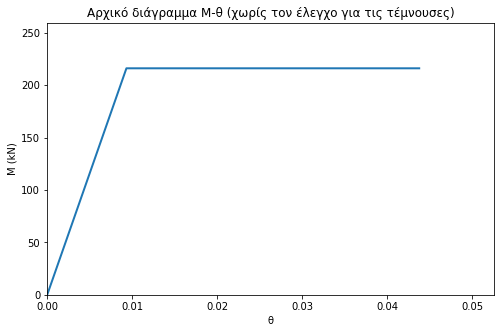

In [21]:
xMθs = [0, θy, θu]
yMθs = [0, My, My]

plt.figure(figsize=(8, 5))
plt.plot(xMθs, yMθs, lw=2)
plt.axis([0, 1.2*θu, 0, 1.2*My])

plt.ylabel('M (kN)') 
plt.xlabel('θ')   
plt.title('Αρχικό διάγραμμα Μ-θ (χωρίς τον έλεγχο για τις τέμνουσες)')
plt.show()

In [22]:
μθ = θu/θy
print(f'Αρχική τιμή πλαστιμότητας στροφών μθ={μθ:.2f}')

Αρχική τιμή πλαστιμότητας στροφών μθ=4.70


### Υπολογισμός διατμητικής αντοχής

In [23]:
# Τέμνουσα που παραλαμβάνουν οι συνδετήρες
Vw = Vwcalc(ρw, b, z, fyw)
print(f'Vw={Vw:.2f}kN={Vw/1000:.5f}MN')

Vw=223.68kN=0.22368MN


In [24]:
xs = np.linspace(0., 1.5*θu, 100)
yVRs = list()
yMs = list()

for x in xs:
    μθpl=max(0, (x/θy)-1)
    VRi=VRcalc(h, xy, Ls , N/1000, b*d, fc/1000, μθpl, ρtot, αs, Vw/1000)*1000
    MVRi = VRi * Ls
    
    yVRs.append(VRi)
    yMs.append(MVRi)

# print(xs)

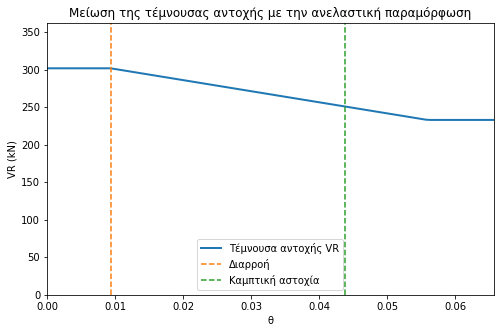

In [25]:
xsy=[θy, θy]
ysy=[0, 1.2*max(yVRs)]

xsu=[θu, θu]
ysu=[0, 1.2*max(yVRs)]

plt.figure(figsize=(8, 5))
plt.plot(xs, yVRs, label="Τέμνουσα αντοχής VR", lw=2)
plt.axis([0, 1.5*θu, 0, 1.2*max(yVRs)])
# plt.axis([0, 8, 0, 1.2*max(VR0*Ls, My)])
plt.plot(xsy, ysy, label="Διαρροή", linestyle='--')
plt.plot(xsu, ysu, label="Καμπτική αστοχία", linestyle='--')
plt.ylabel('VR (kN)') 
plt.xlabel('θ')   
plt.title('Μείωση της τέμνουσας αντοχής με την ανελαστική παραμόρφωση')
plt.legend()
plt.show()

### Έλεγχος πρόωρης αστοχίας από διάτμηση

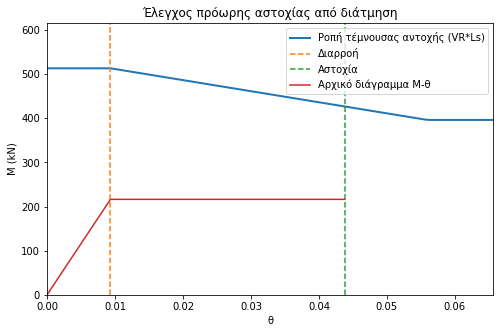

In [26]:
ymax = max(max(yMs), My)

xsy=[θy, θy]
ysy=[0, 1.2*ymax]

xsu=[θu, θu]
ysu=[0, 1.2*ymax]

xMθs = [0, θy, θu]
yMθs = [0, My, My]

plt.figure(figsize=(8, 5))
plt.plot(xs, yMs, label="Ροπή τέμνουσας αντοχής (VR*Ls)", lw=2)
plt.axis([0, 1.5*θu, 0, 1.2*ymax])
# plt.axis([0, 8, 0, 1.2*max(VR0*Ls, My)])
plt.plot(xsy, ysy, label="Διαρροή", linestyle='--')
plt.plot(xsu, ysu, label="Αστοχία", linestyle='--')
plt.plot(xMθs, yMθs, label="Αρχικό διάγραμμα Μ-θ")

plt.ylabel('M (kN)') 
plt.xlabel('θ')   
plt.title('Έλεγχος πρόωρης αστοχίας από διάτμηση')
plt.legend()
plt.show()

In [27]:
υ = Symbol('υ')
μθsol=solve((((h-xy)/(2*Ls))*min(N/1000, 0.55*b*d*fc/1000) + (1-0.05*υ) * (0.16*max(0.5, 100*ρtot)*(1-0.16*min(5,αs))*((fc/1000)**0.5)*b*d + Vw/1000)*1000-My/Ls),υ)[0]
θsol = θy * (μθsol+1)
# print(μθsol)
# print(θsol)

In [28]:
VR0 = yVRs[0]
if VR0 < My/Ls:
    θu = 1.4 * θy
    θy = θy * VR0 * Ls / My     
    My = VR0 * Ls   

elif θsol<θu:
    θu = θsol    

print('Τελικές τιμές')
print(f'My=Mu={My:.2f}kNm')
print(f'θy={θy:.4f}')
print(f'θu={θu:.4f}')

Τελικές τιμές
My=Mu=216.21kNm
θy=0.0093
θu=0.0438


## Τελικό διάγραμμα Μ-θ

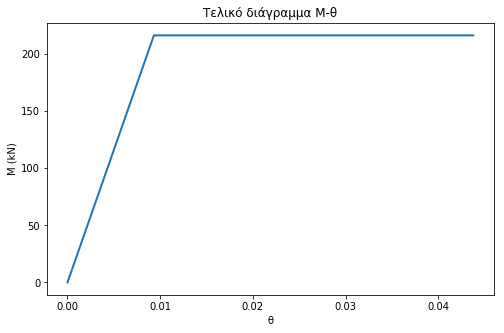

In [29]:
xMθs = [0, θy, θu]
yMθs = [0, My, My]

plt.figure(figsize=(8, 5))
plt.plot(xMθs, yMθs, lw=2)
# plt.axis([0, 1.2*θu, 0, 1.2*My])

plt.ylabel('M (kN)') 
plt.xlabel('θ')   
plt.title('Τελικό διάγραμμα Μ-θ')
plt.show()

## Αποτελέσματα για το SAP2000

### Δεδομένα πλαστικής άρθρωσης (*Hinge Property*)

Στις ιδιότητες των πλαστικών αρθρώσεων του SAP2000 δίνεται η τιμή της πλαστικής στροφής $θ_{pl}=θ_{u}-θ_{y}$

Στο σημείο της θεωρητικής αστοχίας λαμβάνεται πτώση αντοχής στο 20% της My και στη συνέχεια δίνεται η δυνατότητα παραμόρφωσης με την ίδια αντοχή έως το $5\cdotθ_{pl}$

In [30]:
θpl = θu - θy
print(f'θpl={θpl:.4f}')

θpl=0.0345


In [31]:
da = {'M': [0, My, My, 0.2*My, 0.2*My], 'θ': [0, 0, θpl, θpl, 5*θpl]}
df = pd.DataFrame(data=da, index=['A', 'B', 'C', 'D', 'E'])
df.round({'M': 2, 'θ': 4})

,M,θ
A,0.00,0.0000
B,216.21,0.0000
C,216.21,0.0345
D,43.24,0.0345
E,43.24,0.1723


### Ενεργός δυσκαμψία. Συντελεστής για SAP

In [32]:
K = My * Ls / (3 * θy)
print(f'K={K:.1f}kNm2')

I = b * h**3 / 12.0
K0 = Ec * I
print(f'K0={K0:.1f}kNm2')

ModFactor = K / K0

print("Modification Factor for SAP=" + "{0:.3f}".format(ModFactor))

K=13138.8kNm2
K0=86454.8kNm2
Modification Factor for SAP=0.152


In [34]:
# print(df.to_latex())